<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Image/Test_Golgi_Quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install opencv-python

In [15]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2
import skimage as ski

In [5]:
def plot_point_data(x,y,z,image_stack,vmin=None,vmax=None,lw=.2,figsize=(3,2.7),cmap='gray',rad=None):
    # () = xyz

    if rad is not None:
        min_x = np.max([x-rad,0])
        max_x = np.min([x+rad,image_stack.shape[0]])
        min_y = np.max([y-rad,0])
        max_y = np.min([y+rad,image_stack.shape[1]])
        image_stack = image_stack[min_y:max_y,min_x:max_x,:]
        x=rad
        y=rad

    fig,ax=plt.subplots(2,2,width_ratios=[5, 1],height_ratios=(5,1),figsize=figsize,dpi=300)
    ax[1,1].axis('off')

    ax[0,0].imshow(image_stack[:,:,z],aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap,zorder=-1)
    ax[0,0].axvline(x,color='m',linewidth=lw)
    ax[0,0].axhline(y,color='c',linewidth=lw)

    collapse_x = image_stack[y,:,:].T
    ax[1,0].imshow(collapse_x,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap,zorder=-1)
    ax[1,0].axhline(z,color='y',linewidth=lw)
    ax[1,0].axvline(x,color='m',linewidth=lw)

    collapse_y =image_stack[:,x,:]
    print(collapse_y.shape)
    ax[0,1].imshow(collapse_y,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap,zorder=-1)
    ax[0,1].axvline(z,color='y',linewidth=lw)
    ax[0,1].axhline(y,color='c',linewidth=lw)


    # if rad is not None:
        # min_x = np.max([x-rad,0])
        # max_x = np.min([x+rad,image_stack.shape[0]])
        # min_y = np.max([y-rad,0])
        # max_y = np.min([y+rad,image_stack.shape[1]])

        # print(min_x,max_x,min_y,max_y)

        # ax[0,0].set_xlim(min_x,max_x)
        # ax[0,0].set_ylim(min_y,max_y)

        # ax[1,0].set_xlim(min_x,max_x)
        # ax[0,1].set_ylim(min_y,max_y)
    return fig,ax


In [6]:
# image_stack.shape

In [7]:
def stack_snake(img_arr,row_n,col_n=None):
    img_arr=np.array(img_arr)
    if col_n is None: col_n=row_n
    X = np.arange(row_n*col_n).reshape(row_n,col_n)
    for r in np.arange(1,row_n,2):
        X[r,:] = X[r,::-1]

    cat_rows = [np.concatenate(img_arr[X[r,:]],axis=1) for r  in range(row_n)]
    concat = np.concatenate(cat_rows,axis=0)
    return concat

def plot_img_grid( images , r,c=None):
    plt.imshow(stack_snake(images,row_n=r,col_n=c))

In [8]:
image_set_dir = "C:\\Users\\dennis.tabuena\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\CA1\\"
image_tag = 'Overlay'

os.chdir(image_set_dir)

tif_list=list()
for dir,root,files in os.walk(image_set_dir):
    for f in files:
        if image_tag in f:
            tif_list.append(os.path.join(dir,f))

pd_dict = {'file_loc': [t for t in tif_list],
           'z': [t.split("_")[-2] for t in tif_list]}
image_df = pd.DataFrame(pd_dict)

display(image_df)


,file_loc,z
0,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00001
1,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00002
2,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00003
3,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00004
4,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00005
...,...,...
167,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00168
168,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00169
169,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00170
170,C:\Users\dennis.tabuena\Dropbox (Gladstone)\0_...,Z00171


In [9]:
"""Build Stack"""
image_stack = list()
for path in image_df['file_loc']:
    image_data =cv2.imread(path)
    # image_data = np.mean(image_data,axis=-1)
    image_data = image_data[:,:,1]
    image_stack.append(image_data)
image_stack=np.stack(image_stack,axis=-1)
print(image_stack.shape)


(1440, 1920, 172)


(500, 172)


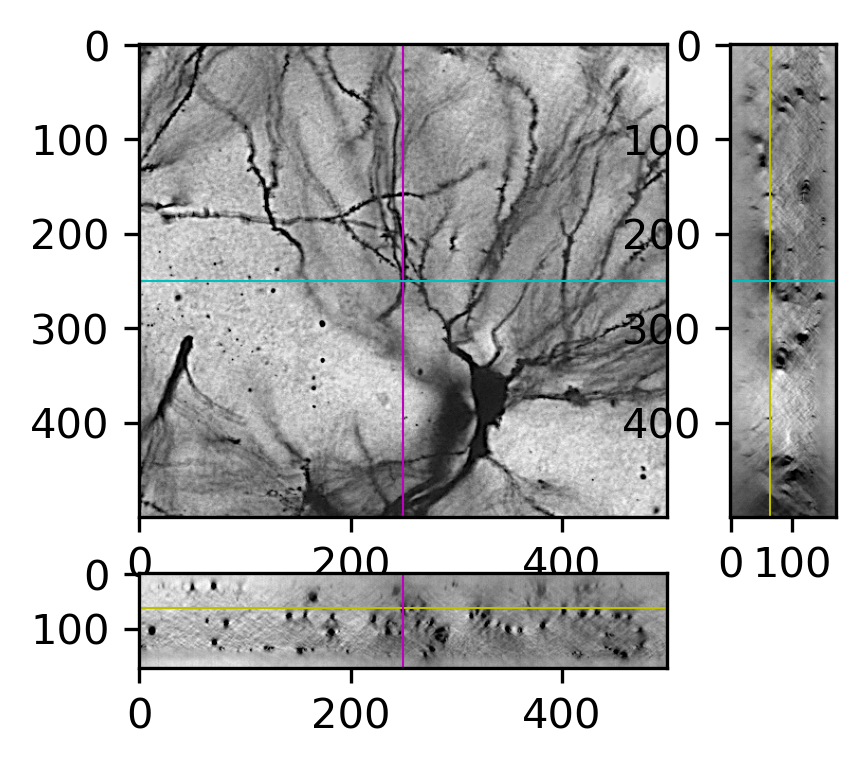

In [10]:
(x,y,z) = (695,435,63)
fig,ax =plot_point_data(x,y,z,image_stack,rad=250,lw=.5)


(500, 172)


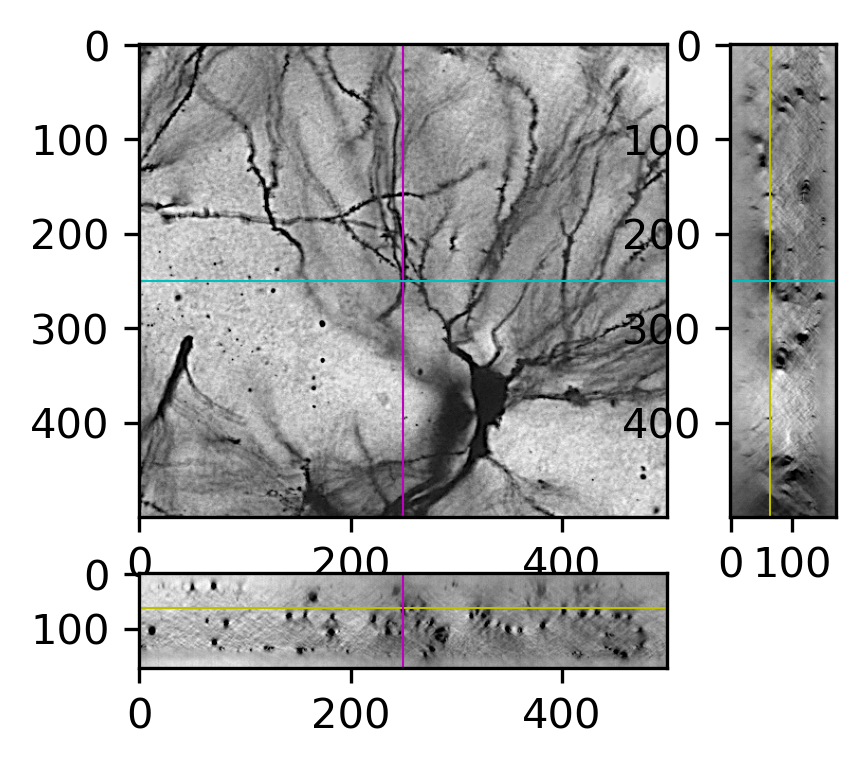

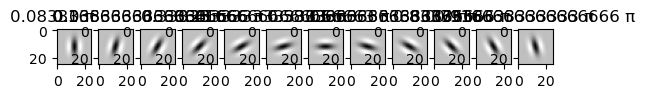

In [16]:
""" Define Filters """
def make_filter_set(gabor_set_def,top=np.pi):
    filter_set=list()
    thetas= np.arange(0,1,1/gabor_set_def['n_ker']) * top
    for theta in thetas:
        filter = np.real(ski.filters.gabor_kernel(gabor_set_def['frequency'],
                                                theta,
                                                sigma_x=gabor_set_def['rad'],
                                                sigma_y=gabor_set_def['len'],
                                                n_stds=gabor_set_def['n_stds'],))
        filter_set.append(-filter)
    filter_set = square_filters(filter_set)
    filter_set = norm_set(filter_set)
    return filter_set,thetas

def norm_set(my_set):
    dims = np.array([(np.min(x),np.max(x)) for x in my_set])
    scalar = 1 / np.max(np.abs(dims))
    my_set = [x*scalar for x in my_set]
    return my_set

def square_filters(filter_set):
    dims = np.array([f.shape for f in filter_set])
    max_d =  np.max(dims)
    for i,filter in enumerate(filter_set):
        f_dim = filter.shape
        delta = max_d-f_dim
        half_delta = (delta/2).astype(int)
        padded= np.pad(filter,((half_delta[0],half_delta[0]),
                               (half_delta[1],half_delta[1]),))
        filter_set[i] = padded
    return filter_set

def conv_filter_set(image_plane,gabor_set_def):
    filter_set = make_filter_set(gabor_set_def)


def plot_filter_set(filter_set,thetas):
    fig,ax=plt.subplots(1,gabor_set_def['n_ker'])
    for (a,f,theta) in zip(ax,filter_set,thetas):
        a.imshow(f,cmap='gray')
        a.set_title(f"{theta/np.pi} π")
        a.set_aspect('equal')
    plt.show()





gabor_set_def = {'rad': 3,
                 'len': 4,
                 'n_ker': 12,
                 'frequency': .1,
                 'n_stds': 3,
                 }

fig,ax = plot_point_data(x,y,z,image_stack,rad=250,lw=.5)
# ax.pcolor(filter,zorder=99)

filter_set,thetas = make_filter_set(gabor_set_def,top=np.pi)
plot_filter_set(filter_set,thetas)


12it [00:44,  3.71s/it]


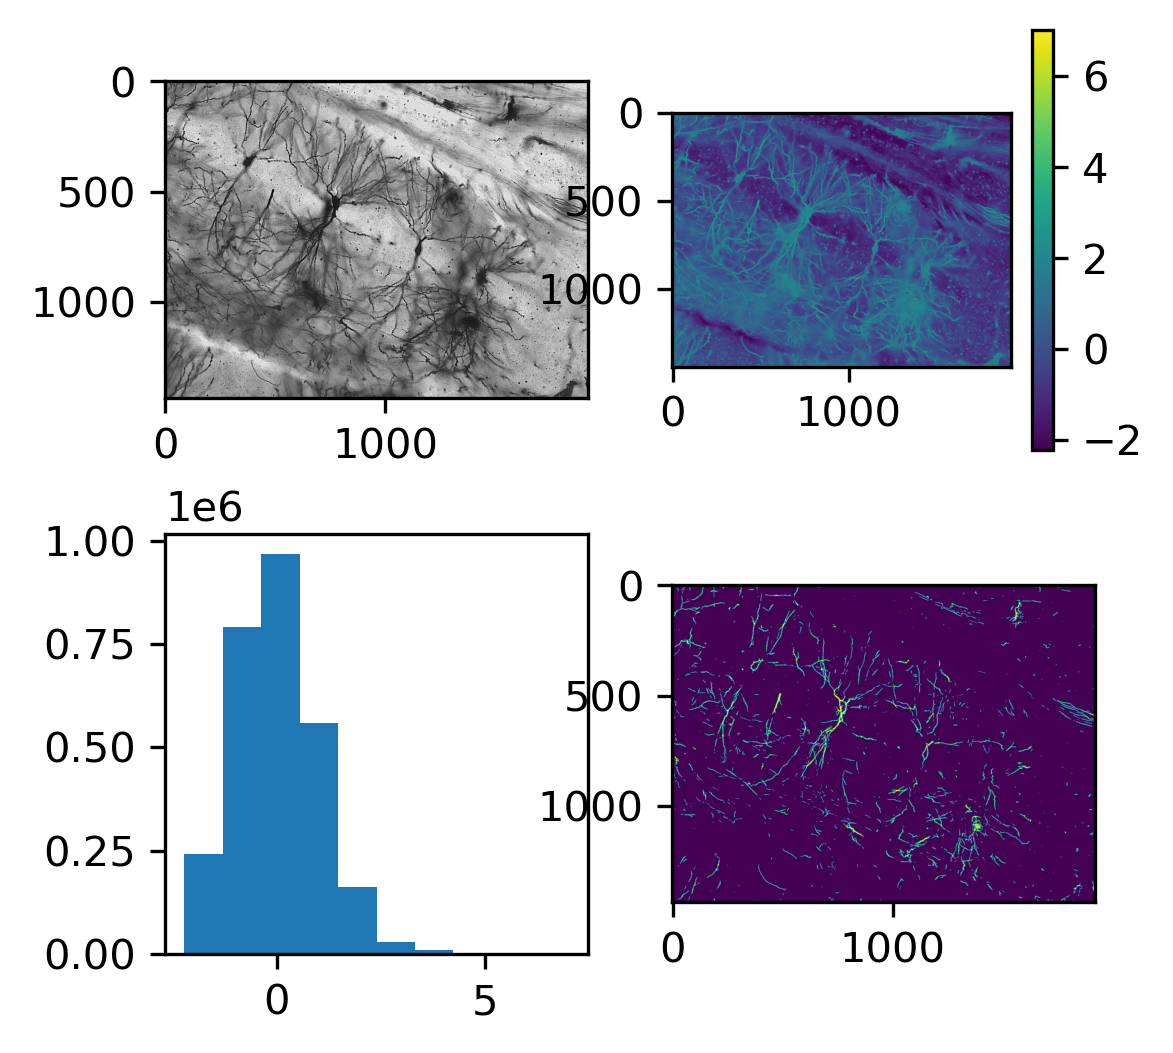

In [33]:
"""START HERE MAKE TOOLS TO DO CONVOLUTION"""
import scipy as sci
def conv_image_filter_set(image,filter_set,thetas):

    results=list()
    for theta,filter in tqdm( zip(thetas,filter_set) ):
        res = sci.signal.convolve2d(image, filter, mode='same',boundary='symm')
        results.append(res)

    return results

(x,y,z) = (600,407,63)
rad = 250
# fig,ax =plot_point_data(x,y,z,image_stack,rad=50,lw=.5)
image = image_stack[y-rad:y+rad,x-rad:x+rad,z]
image = image_stack[:,:,z]

results = conv_image_filter_set(image,filter_set,thetas)

X = np.stack(results,axis=0)
X = (X-np.mean(X.flatten()))/np.std(X.flatten())


greedy_conv = np.max(X,axis=0)

greedy_conv = (greedy_conv-np.mean(greedy_conv.flatten()))/np.std(greedy_conv.flatten())

fig,ax=plt.subplots(2,2,figsize=(4,4),dpi=300)
ax=ax.flatten()
ax[0].imshow(image,cmap='gray')
cbh = ax[1].imshow(greedy_conv)
plt.colorbar(cbh)
his = ax[2].hist(greedy_conv.flatten())
ax[3].imshow(greedy_conv>2)

In [18]:
from tqdm import tqdm

In [ ]:
def conv_full_stack(image_stack,gabor_set_def=None,ds=1):
    if gabor_set_def is None:
        gabor_set_def = {'rad': 3,
                 'len': 8,
                 'n_ker': 12,
                 'frequency': .1,
                 'n_stds': 3,
                 }

    gabor_set_def['rad'] = gabor_set_def['rad']/ds
    gabor_set_def['len'] = gabor_set_def['len']/ds
    gabor_set_def['frequency'] = gabor_set_def['frequency']*ds

    if ds>1:
        image_stack=image_stack[::ds,::ds,:]


    filter_set,thetas = make_filter_set(gabor_set_def,top=np.pi)
    greedy_stack = np.ones_like(image_stack)*np.nan

    for z in range(image_stack.shape[-1]):
        print("\n",z)
        image=image_stack[:,:,z]
        results = conv_image_filter_set(image,filter_set,thetas)
        greedy_results = np.max(np.stack(results,axis=0),axis=0)
        greedy_stack[:,:,z] = greedy_results

    return greedy_stack

greedy_stack = conv_full_stack(image_stack[:,:,1:10],gabor_set_def=None)



 0


12it [03:00, 15.07s/it]



 1


6it [01:30, 15.15s/it]

In [ ]:
# def pol2cart(rho, phi):
#     x = rho * np.cos(phi)
#     y = rho * np.sin(phi)
#     return(x, y)


0